# Montar carpeta de drive

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
# !pip install scikit-learn
# !pip install opencv-python
# !pip install matplotlib
# !conda install Pillow
#!pip install mlxtend

#import tensorflow as tf
#print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))




# Clasificador de imágenes

In [1]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.utils import to_categorical
import os
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import math
%matplotlib inline

# Configuración de parámetros

In [2]:
width_shape = 224
height_shape = 224
num_classes = 24
epochs = 100
batch_size = 32
image_shape = (224,224,3)

# Path de dataset

In [3]:
train_data_dir = r'C:\Users\johns\Desktop\TFG\Dataset\train'
validation_data_dir = r'C:\Users\johns\Desktop\TFG\Dataset\valid'

# Generador de imágenes (entrenamiento y validación) VGG16

In [5]:
# Data generators with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, # Últimos cambios añadidos de una consulta
    rotation_range=10,
    zoom_range=0.1,  # Reducido de 0.2 a 0.1
    width_shift_range=0.1,  # Reducido de 0.2 a 0.1
    height_shift_range=0.1,  # Reducido de 0.2 a 0.1
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest', # Últimos cambios añadidos de una consulta
    # preprocessing_function=preprocess_input comentamos esto que es de vgg16
    )

valid_datagen = ImageDataGenerator(rescale=1./255) # Sin aumentos de datos para la validación

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

validation_generator = valid_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

Found 12396 images belonging to 24 classes.
Found 2564 images belonging to 24 classes.


# Entrenamiento de modelo VGG16

In [6]:
import sys
from PIL import Image
sys.modules['Image'] = Image 
nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples

# Load pre-trained VGG16 model
image_input = Input(shape=(width_shape, height_shape, 3))
base_model = VGG16(input_tensor=image_input, include_top=False, weights='imagenet')

# Adding custom layers
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Creating final model
custom_vgg_model = Model(inputs=base_model.input, outputs=predictions)

# Freezing layers from original VGG16 model
for layer in base_model.layers:
    layer.trainable = False

# Compilando el modelo con Adam
custom_vgg_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Definir ModelCheckpoint
checkpoint = ModelCheckpoint(r'C:\Users\johns\Desktop\TFG\Dataset\VGG16\best_vgg16_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo con ModelCheckpoint
model_history = custom_vgg_model.fit(
    train_generator,
    steps_per_epoch=math.ceil(nb_train_samples / batch_size),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=math.ceil(nb_validation_samples / batch_size),
    callbacks=[checkpoint,reduce_lr,early_stopping])

Epoch 1/100
388/388 [==============================] - ETA: 0s - loss: 2.8637 - accuracy: 0.1753
Epoch 1: val_accuracy improved from -inf to 0.34828, saving model to C:\Users\johns\Desktop\TFG\Dataset\VGG16\best_vgg16_model.h5
388/388 [==============================] - 142s 356ms/step - loss: 2.8637 - accuracy: 0.1753 - val_loss: 2.1585 - val_accuracy: 0.3483 - lr: 0.0010
Epoch 2/100
388/388 [==============================] - ETA: 0s - loss: 2.3229 - accuracy: 0.2694
Epoch 2: val_accuracy improved from 0.34828 to 0.39236, saving model to C:\Users\johns\Desktop\TFG\Dataset\VGG16\best_vgg16_model.h5
388/388 [==============================] - 126s 324ms/step - loss: 2.3229 - accuracy: 0.2694 - val_loss: 2.0047 - val_accuracy: 0.3924 - lr: 0.0010
Epoch 3/100
388/388 [==============================] - ETA: 0s - loss: 2.2247 - accuracy: 0.2875
Epoch 3: val_accuracy improved from 0.39236 to 0.40874, saving model to C:\Users\johns\Desktop\TFG\Dataset\VGG16\best_vgg16_model.h5
388/388 [========

# Grabar modelo en disco

In [7]:
# Guardar el modelo
custom_vgg_model.save(r"C:\Users\johns\Desktop\TFG\Dataset\VGG16\custom_vgg16_model.h5")

# Gráficas de entrenamiento y validación (accuracy - loss)

In [8]:
def plotTraining(hist, epochs, typeData):

    if typeData=="loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'-r',label='Loss Training')
    if typeData=="accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'-r',label='Accuracy Training')
    if typeData=="val_loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['val_loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'-b',label='Loss Validate')
    if typeData=="val_accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['val_accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'-b',label='Training Validate')


    plt.rc('xtick',labelsize=24)
    plt.rc('ytick',labelsize=24)
    plt.rc('legend', fontsize=18)
    plt.legend()
    plt.xlabel('Number of Epochs',fontsize=24)
    plt.grid(True)

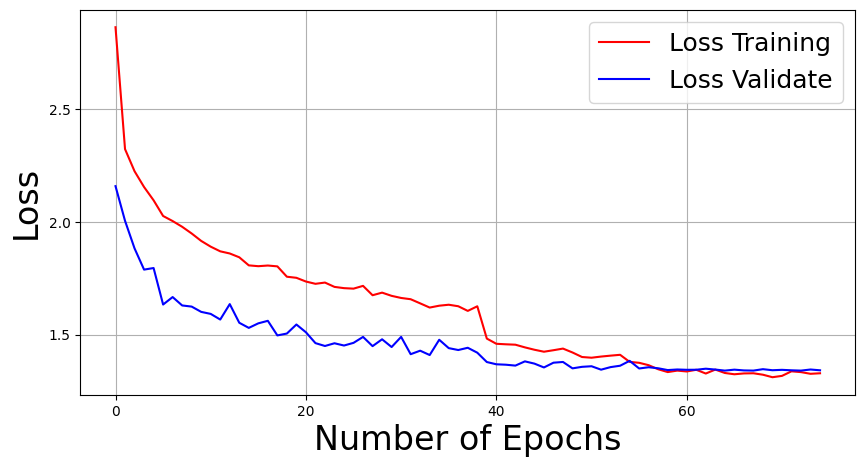

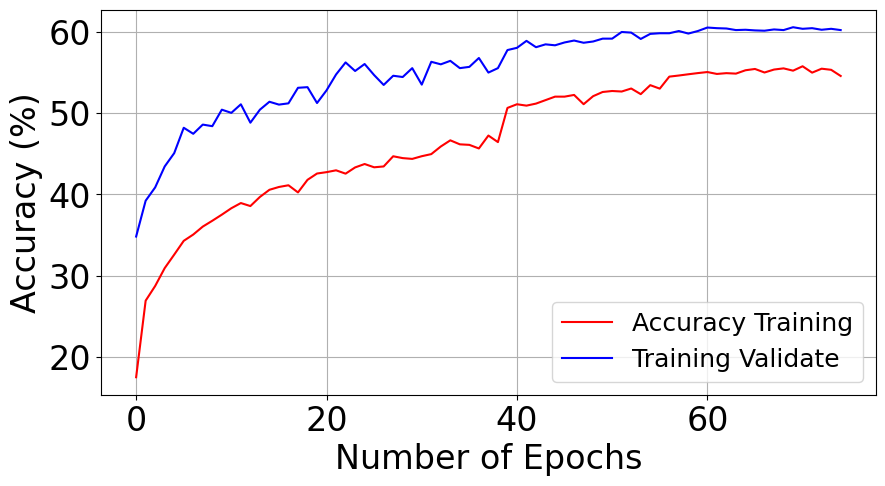

In [9]:
num_epochs_done = len(model_history.history['loss'])

plotTraining(model_history,num_epochs_done,"loss")
plotTraining(model_history,num_epochs_done,"accuracy")
plotTraining(model_history,num_epochs_done,"val_loss")
plotTraining(model_history,num_epochs_done,"val_accuracy")


# Predicción usando el modelo entrenado

AGUJA COLINERA


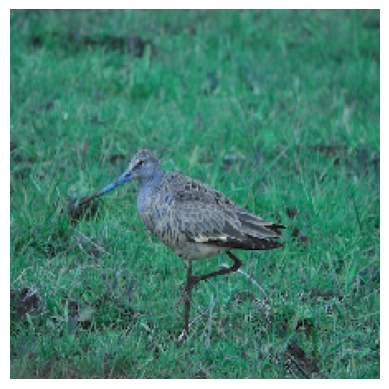

In [5]:
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array

# nombres de las clases
names = ['AGUJA COLINERA',
          'ALCA COMÚN',
          'AVEFRÍA EUROPEA',
          'AVIÓN ROQUERO',
          'AVOCETA COMÚN',
          'CHARRÁN PATINEGRO',
          'CHORLITO DORADO EUROPEO',
          'ESTORNINO PINTO',
          'FLAMENCO COMUN',
          'FOCHA COMUN',
          'GARCILLA VUEYERA OCCIDENTAL',
          'GAVIOTA PATIAMARILLA',
          'GAVIOTA PICOFINA',
          'GAVIOTA REIDORA',
          'GOLONDRINA COMUN',
          'GORRIÓN COMÚN',
          'GRAJILLA OCCIDENTAL',
          'JILGUERO EUROPEO',
          'MORITO COMÚN',
          'PALOMA TORCAZ',
          'PARDELA BALEAR',
          'PATO CUCHARÓN NORTEÑO',
          'SERÍN VERDECILLO',
          'VENCEJO COMÚN']

# cargar el modelo
modelt = load_model(r"C:\Users\johns\Desktop\TFG\Dataset\VGG16\custom_vgg16_model.h5")
# modelt = load_model("custom_resnetv2_model.h5")

# ruta de la imagen
imaget_path = r'C:\Users\johns\Desktop\TFG\Dataset\test\AGUJA COLINEGRA\5.jpg'

# cargar y redimensionar la imagen
imaget = load_img(imaget_path, target_size=(width_shape, height_shape))
imaget = img_to_array(imaget)
imaget = imaget.reshape((1,) + imaget.shape)

# preprocesar la imagen
xt = imaget / 255.0  # Normalizar la imagen

# hacer predicciones
preds = modelt.predict(xt)

# obtener la clase predicha
predicted_class = np.argmax(preds)
class_name = names[predicted_class]

print(class_name)

# mostrar la imagen
plt.imshow(cv2.cvtColor(imaget.reshape(width_shape, height_shape, 3).astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Matriz de confusión y métricas de desempeño

Found 1873 images belonging to 24 classes.


C:\Users\johns\AppData\Local\Temp\ipykernel_12452\1591172014.py:49: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = custom_Model.predict_generator(generator=test_generator, steps=len(test_generator))
C:\Users\johns\anaconda3\envs\prueba\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\johns\anaconda3\envs\prueba\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\johns\anaconda3\envs

              precision    recall  f1-score   support

           0     0.8571    0.4320    0.5745       125
           1     0.7231    0.3917    0.5081       120
           2     0.6479    0.3833    0.4817       120
           3     1.0000    0.0286    0.0556       105
           4     0.8846    0.3833    0.5349        60
           5     0.8182    0.1084    0.1915        83
           6     0.8261    0.3167    0.4578        60
           7     0.3945    0.5584    0.4624        77
           8     0.7111    0.6400    0.6737        50
           9     0.3670    0.5714    0.4469        70
          10     0.6618    0.5625    0.6081        80
          11     0.2828    0.2947    0.2887        95
          12     0.0000    0.0000    0.0000         6
          13     0.3073    0.9265    0.4615        68
          14     0.2593    0.6562    0.3717        64
          15     0.3548    0.1692    0.2292        65
          16     0.4079    0.4429    0.4247        70
          17     0.3154    

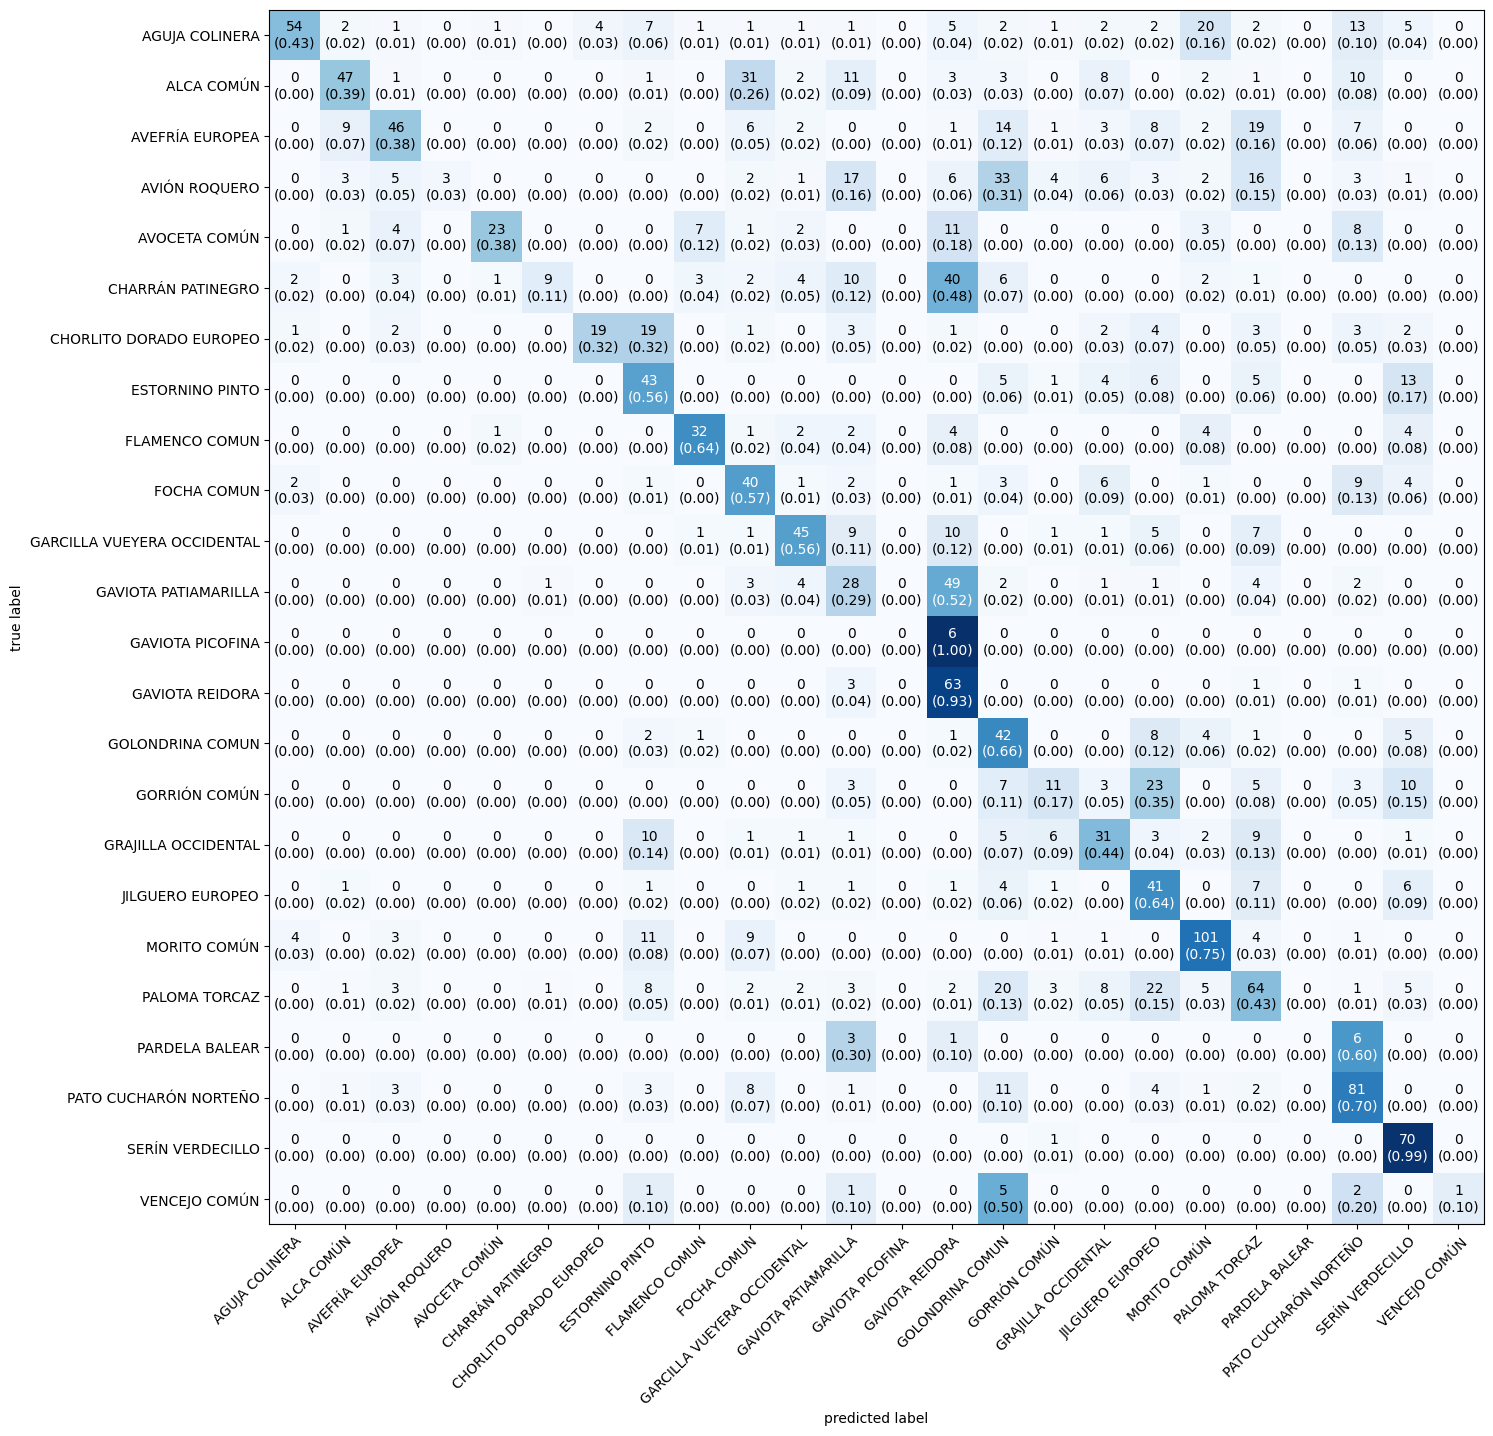

In [6]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# nombres de las clases
names = ['AGUJA COLINERA',
          'ALCA COMÚN',
          'AVEFRÍA EUROPEA',
          'AVIÓN ROQUERO',
          'AVOCETA COMÚN',
          'CHARRÁN PATINEGRO',
          'CHORLITO DORADO EUROPEO',
          'ESTORNINO PINTO',
          'FLAMENCO COMUN',
          'FOCHA COMUN',
          'GARCILLA VUEYERA OCCIDENTAL',
          'GAVIOTA PATIAMARILLA',
          'GAVIOTA PICOFINA',
          'GAVIOTA REIDORA',
          'GOLONDRINA COMUN',
          'GORRIÓN COMÚN',
          'GRAJILLA OCCIDENTAL',
          'JILGUERO EUROPEO',
          'MORITO COMÚN',
          'PALOMA TORCAZ',
          'PARDELA BALEAR',
          'PATO CUCHARÓN NORTEÑO',
          'SERÍN VERDECILLO',
          'VENCEJO COMÚN']

test_data_dir = r'C:\Users\johns\Desktop\TFG\Dataset\test'

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False)

custom_Model= load_model(r"C:\Users\johns\Desktop\TFG\Dataset\VGG16\custom_vgg16_model.h5")

predictions = custom_Model.predict_generator(generator=test_generator, steps=len(test_generator))

y_pred = np.argmax(predictions, axis=1)
y_real = test_generator.classes

matc=confusion_matrix(y_real, y_pred)

#show_normed: es para normalizar la salida de la matriz de confusion entre 0 y 1.
plot_confusion_matrix(conf_mat=matc, figsize=(15, 15), class_names=names, show_normed=True)
plt.tight_layout()

print(metrics.classification_report(y_real,y_pred, digits = 4))

In [7]:
print(y_real)

[ 0  0  0 ... 23 23 23]


In [8]:
print(y_pred)

[21 14 21 ... 21 23 14]
